<a href="https://colab.research.google.com/github/armony1/Banking-Competition/blob/master/Banking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Not: Paylaşılmadan öne cümleler düzeltilecek, yazılar düzeltilecek vs vs.

In [0]:
from google.colab import files
uploaded = files.upload()

Saving test1.csv to test1.csv
Saving train1.csv to train1.csv


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from lightgbm import LGBMClassifier

In [0]:
train = pd.read_csv("/content/train1.csv")
test = pd.read_csv("/content/test1.csv")

In [317]:
train.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


In [318]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan_ID                  164309 non-null  int64  
 1   Loan_Amount_Requested    164309 non-null  object 
 2   Length_Employed          156938 non-null  object 
 3   Home_Owner               138960 non-null  object 
 4   Annual_Income            139207 non-null  float64
 5   Income_Verified          164309 non-null  object 
 6   Purpose_Of_Loan          164309 non-null  object 
 7   Debt_To_Income           164309 non-null  float64
 8   Inquiries_Last_6Mo       164309 non-null  int64  
 9   Months_Since_Deliquency  75930 non-null   float64
 10  Number_Open_Accounts     164309 non-null  int64  
 11  Total_Accounts           164309 non-null  int64  
 12  Gender                   164309 non-null  object 
 13  Interest_Rate            164309 non-null  int64  
dtypes: f

* We are not gonna use Loan_ID, so i'll just drop it.
* And it seems like Loan_Amount_Requested column is object, so i'll make that column numeric.

In [0]:
train.drop("Loan_ID",axis=1,inplace=True)

In [0]:
train["Loan_Amount_Requested"] = train["Loan_Amount_Requested"].str.replace(",","")
train["Loan_Amount_Requested"] = pd.to_numeric(train["Loan_Amount_Requested"])

test["Loan_Amount_Requested"] = test["Loan_Amount_Requested"].str.replace(",","")
test["Loan_Amount_Requested"] = pd.to_numeric(test["Loan_Amount_Requested"])

In [0]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [396]:
missing_values_table(train)

Your selected dataframe has 13 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
Months_Since_Deliquency,88379,53.8
Home_Owner,25349,15.4
Annual_Income,25102,15.3
Length_Employed,7371,4.5


It is suggested that if a column has more than 50% missing values it's better to be dropped. But we will see that if we can use that column and if we get a better result we can keep it.

# Exploratory Data Analysis

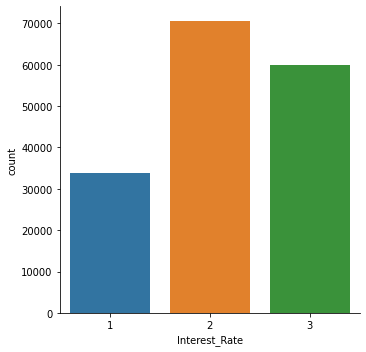

In [0]:
sns.catplot(x = "Interest_Rate", data =train, kind="count")
plt.show()

* Our target column, we have some imbalance bot not so important.

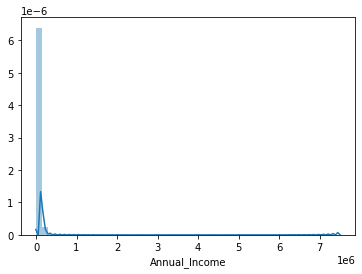

In [0]:
sns.distplot(train["Annual_Income"])
plt.show()

* As you can see we have a very loooooong tail. This is caused by the outliers.
* We'll check out the distribution and we'll delete those outliers.

In [0]:
train["Annual_Income"].describe()

count    1.392070e+05
mean     7.333116e+04
std      6.037750e+04
min      4.000000e+03
25%      4.500000e+04
50%      6.300000e+04
75%      8.869750e+04
max      7.500000e+06
Name: Annual_Income, dtype: float64

In [0]:
train["Annual_Income"].sort_values(ascending = False).head(15)

88088     7500000.0
156075    7141778.0
135686    5000000.0
159569    4900000.0
111833    4560077.0
148308    3900000.0
97248     2000000.0
6450      1950000.0
154211    1900000.0
58993     1600000.0
26486     1350000.0
106988    1200000.0
90841     1200000.0
144862    1176000.0
144118    1084773.0
Name: Annual_Income, dtype: float64

* As you can see mean is approximately 73k. But some of our values are more than 5 million.
* This is hurting our distribution so we'll drop these extreme outliers.

In [0]:
Q1 = train["Annual_Income"].quantile(0.25)
Q3 = train["Annual_Income"].quantile(0.75)

IQR = Q3 - Q1

train = train[train["Annual_Income"].fillna(1) < (Q3 + 3 * IQR)]
# I did not drop the lower values because of NaN's and if you calculate the Q1 - 3 * IQR you'll see that its lower than 0, so even if i dropped them not would change.

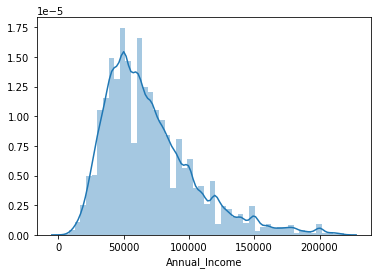

In [398]:
sns.distplot(train["Annual_Income"])
plt.show()

* we still have skewed data, is less.

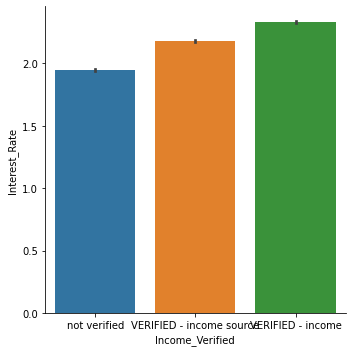

VERIFIED - income           49356
VERIFIED - income source    44093
not verified                43874
Name: Income_Verified, dtype: int64

In [0]:
sns.catplot(x="Income_Verified",y="Interest_Rate",data=train,kind="bar")
plt.show()
train["Income_Verified"].value_counts()

* As you can see if income is not verified Interest_Rate is going lower.

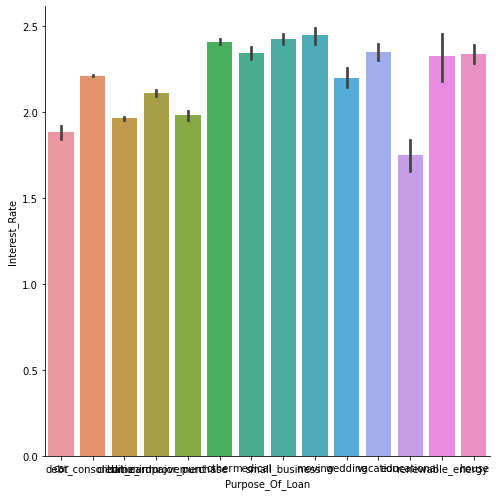

debt_consolidation    96182
credit_card           36283
home_improvement       9017
other                  8235
major_purchase         3383
small_business         2316
car                    1873
medical                1524
moving                  966
vacation                833
wedding                 819
house                   754
renewable_energy        120
educational             120
Name: Purpose_Of_Loan, dtype: int64

In [0]:
sns.catplot(x="Purpose_Of_Loan",y="Interest_Rate",data=train,kind="bar",height=7)
plt.show()
train["Purpose_Of_Loan"].value_counts()

* Some of the Loan Purposes are lower than others. Like house and debt consolidation.

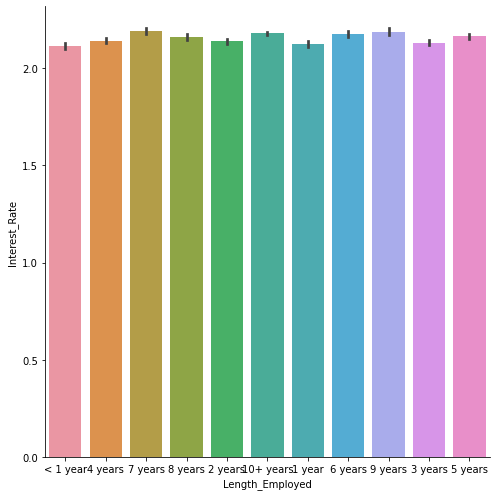

10+ years    52235
2 years      14441
3 years      12813
< 1 year     12688
5 years      10697
1 year       10315
4 years       9669
7 years       9194
6 years       8994
8 years       7815
9 years       6208
Name: Length_Employed, dtype: int64

In [0]:
sns.catplot(x="Length_Employed",y="Interest_Rate",data=train,kind="bar",height=7)
plt.show()
train["Length_Employed"].value_counts()

* All of the probabilities are close to each other.

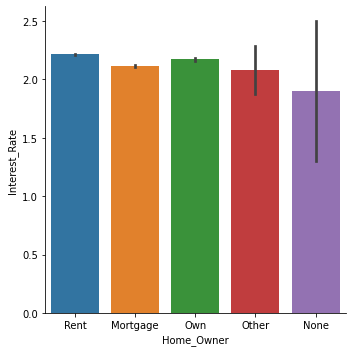

Mortgage    69188
Rent        55727
Own         12368
Other          49
None           10
Name: Home_Owner, dtype: int64

In [0]:
sns.catplot(x="Home_Owner",y="Interest_Rate",data=train,kind="bar")
plt.show()
train["Home_Owner"].value_counts()

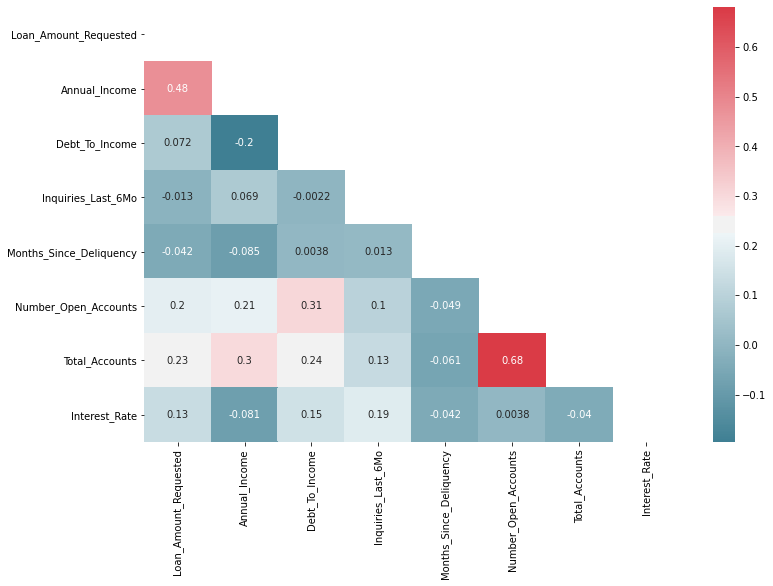

In [0]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(12, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, ax=ax,)
plt.show()

* We can see that there is correlation between total accounts and number of open accounts (normally) but no correlation between number of open accounts.
* So we have a collinear feature and if we keep both we'll just add more complexity to the our model. We'll deal with it in feature engineering section.
* And we can see that we have a correlation with our target feature Interest_Rate with, Loan_Amount_Requested, Debt_To_Income and Inquiries_Last_6Mo 0.13, 0.15, 0.19 respectively.

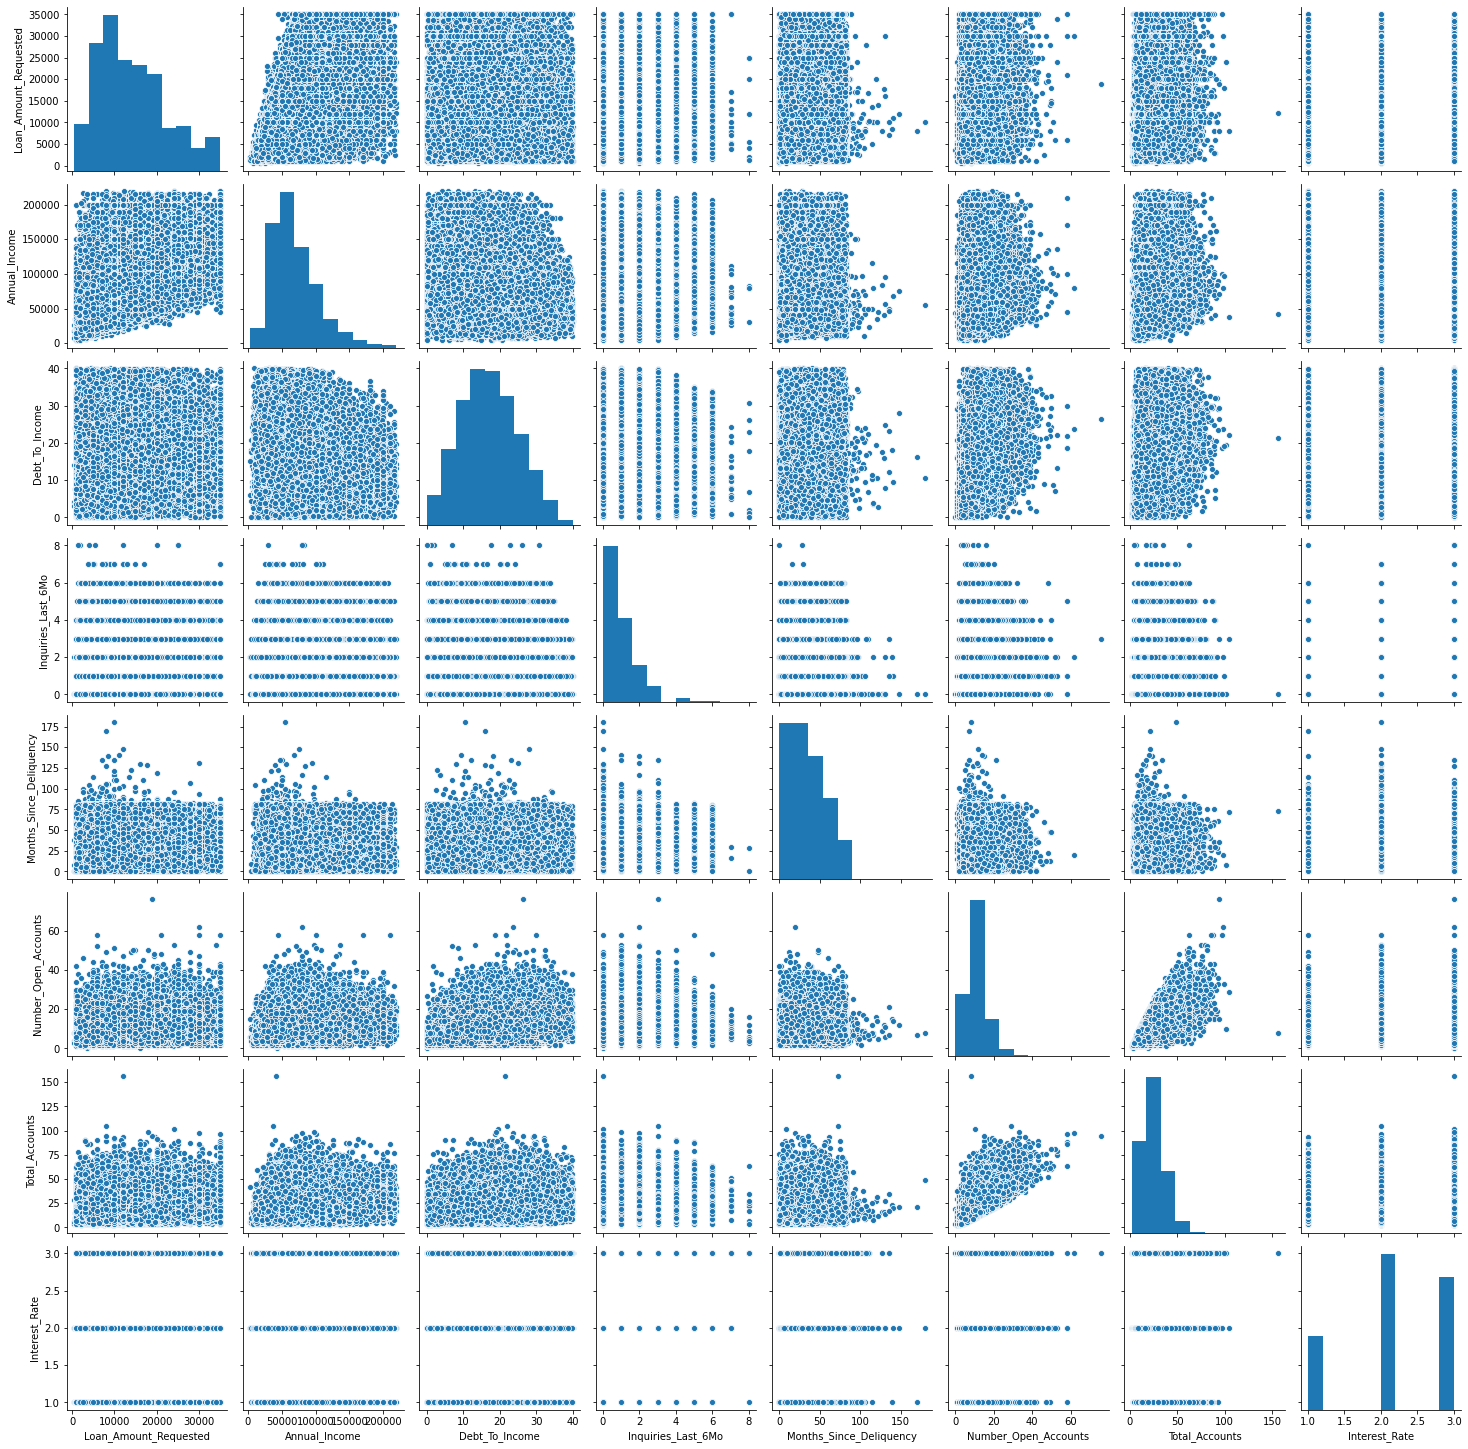

In [0]:
sns.pairplot(train)

explain pair plot

# Feature Engineering and Selection

like i said earlier month since dependency column has so many missing values so ill drop it and num of open accounts

In [0]:
train["Total_Inv_Accounts"] = train["Total_Accounts"] - train["Number_Open_Accounts"]
train.drop(["Months_Since_Deliquency","Total_Accounts"],axis=1,inplace=True)

test["Total_Inv_Accounts"] = test["Total_Accounts"] - test["Number_Open_Accounts"]
test.drop(["Months_Since_Deliquency","Total_Accounts"],axis=1,inplace=True)

In [0]:
enc = LabelEncoder()
train["Length_Employed"].fillna(train["Length_Employed"].mode(),inplace= True)
train["Length_Employed"] = enc.fit_transform(train["Length_Employed"].astype("str"))
test["Length_Employed"] = enc.transform(test["Length_Employed"].astype("str"))

train["Home_Owner"].fillna(train["Home_Owner"].mode(),inplace= True)
train["Home_Owner"] = enc.fit_transform(train["Home_Owner"].astype("str"))
test["Home_Owner"] = enc.transform(test["Home_Owner"].astype("str"))

train["Income_Verified"] = enc.fit_transform(train["Income_Verified"])
test["Income_Verified"] = enc.fit_transform(test["Income_Verified"])

train["Purpose_Of_Loan"] = enc.fit_transform(train["Purpose_Of_Loan"])
test["Purpose_Of_Loan"] = enc.fit_transform(test["Purpose_Of_Loan"])

train["Gender"] = enc.fit_transform(train["Gender"])
test["Gender"] = enc.fit_transform(test["Gender"])

In [401]:
train.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Gender,Interest_Rate,Total_Inv_Accounts
0,7000,10,4,68000.0,2,0,18.37,0,9,0,1,5
1,30000,4,0,NaN,0,2,14.93,0,12,0,3,12
2,24725,7,0,75566.4,1,2,15.88,0,12,1,3,4
3,16000,10,5,56160.0,1,2,14.34,3,16,1,3,6
4,17000,8,3,96000.0,1,2,22.17,1,19,0,1,11


In [0]:
imputer = IterativeImputer(min_value = 4000)

In [0]:
data_imputed = train.copy(deep = True)

In [0]:
num_cols = ["Loan_Amount_Requested","Annual_Income","Debt_To_Income","Inquiries_Last_6Mo","Total_Inv_Accounts"]
data_imputed.loc[:, num_cols] = imputer.fit_transform(data_imputed.loc[:, num_cols])
test_imputed.loc[:, num_cols] = imputer.transform(test.loc[:, num_cols])

In [409]:
data_imputed.isnull().sum()

Loan_Amount_Requested    0
Length_Employed          0
Home_Owner               0
Annual_Income            0
Income_Verified          0
Purpose_Of_Loan          0
Debt_To_Income           0
Inquiries_Last_6Mo       0
Number_Open_Accounts     0
Gender                   0
Interest_Rate            0
Total_Inv_Accounts       0
dtype: int64

In [374]:
data_imputed.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Gender,Interest_Rate,Total_Inv_Accounts
0,7000.0,10,4,68000.000000,2,0,18.37,0.0,9,0,1.0,5.0
1,30000.0,4,0,96195.116709,0,2,14.93,0.0,12,0,3.0,12.0
2,24725.0,7,0,75566.400000,1,2,15.88,0.0,12,1,3.0,4.0
3,16000.0,10,5,56160.000000,1,2,14.34,3.0,16,1,3.0,6.0
4,17000.0,8,3,96000.000000,1,2,22.17,1.0,19,0,1.0,11.0


In [413]:
test_imputed.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Gender,Total_Inv_Accounts
0,10164310,27500.0,1,0,129000.0,0,2,12.87,0.0,10,1,27.0
1,10164311,26000.0,1,5,110000.0,2,1,11.37,0.0,6,1,17.0
2,10164312,6075.0,10,4,75000.0,0,2,6.83,2.0,5,1,15.0
3,10164313,12000.0,1,0,73000.0,1,2,7.76,0.0,6,1,2.0
4,10164314,35000.0,10,0,156000.0,2,2,9.62,0.0,9,1,12.0


In [412]:
test_imputed.isnull().sum()

Loan_ID                  0
Loan_Amount_Requested    0
Length_Employed          0
Home_Owner               0
Annual_Income            0
Income_Verified          0
Purpose_Of_Loan          0
Debt_To_Income           0
Inquiries_Last_6Mo       0
Number_Open_Accounts     0
Gender                   0
Total_Inv_Accounts       0
dtype: int64

In [0]:
test_loan = test_imputed["Loan_ID"]
test_imputed.drop("Loan_ID",axis=1,inplace=True)

# Modeling

In [0]:
X = data_imputed.drop("Interest_Rate",axis=1)
y = data_imputed["Interest_Rate"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state=42)

In [0]:
xg = XGBClassifier(max_depth=4,n_estimators= 300,objective = "multi:softmax")

In [426]:
xg.fit(X_train,y_train)
preds = xg.predict(X_test)
print("score: ",f1_score(y_test,preds,average="weighted"))

score:  0.5181737103941209


In [0]:
params = {
  'min_child_weight':[5,6],
  'max_depth': range(3,10,2),
  'n_estimators':[150,200,300,400],
  'scale_pos_weight':[1,2,3,4],
  'colsample_bytree':[0.7,0.8], 
  'subsample':[0.7,0.8],
  'gamma':[0,0.2,0.4]    
}

model = RandomizedSearchCV(estimator=XGBClassifier(objective="multi:softmax"),param_distributions=params,cv=StratifiedKFold(n_splits=5),scoring="f1_weighted",n_jobs=5,verbose=1)
model.fit(X_train,y_train)
model.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 68.9min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed: 82.2min finished


{'colsample_bytree': 0.8,
 'gamma': 0.2,
 'max_depth': 5,
 'min_child_weight': 6,
 'n_estimators': 300,
 'scale_pos_weight': 4,
 'subsample': 0.8}

In [0]:
xg2 = XGBClassifier(base_score=0.5, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              missing=None, n_estimators=300, n_jobs=-1,
              nthread=4, objective='multi:softmax',
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [430]:
xg2.fit(X_train, y_train)
preds2 = xg2.predict(X_test)
print("score: ", f1_score(y_test,preds2,average="weighted"))

score:  0.5196157407274781


In [0]:
test_preds = pd.Series(xg2.predict(test_imputed), name ="Interest_Rate").astype(int)
results = pd.concat([test_loan,test_preds],axis=1)
results.to_csv("new11.csv",index=False)